<a href="https://colab.research.google.com/github/surajK610/AI/blob/master/Akash_Valkyrie_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, mean_absolute_percentage_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

from scipy.special import boxcox1p

In [36]:
df = pd.read_csv('interview_data.csv')

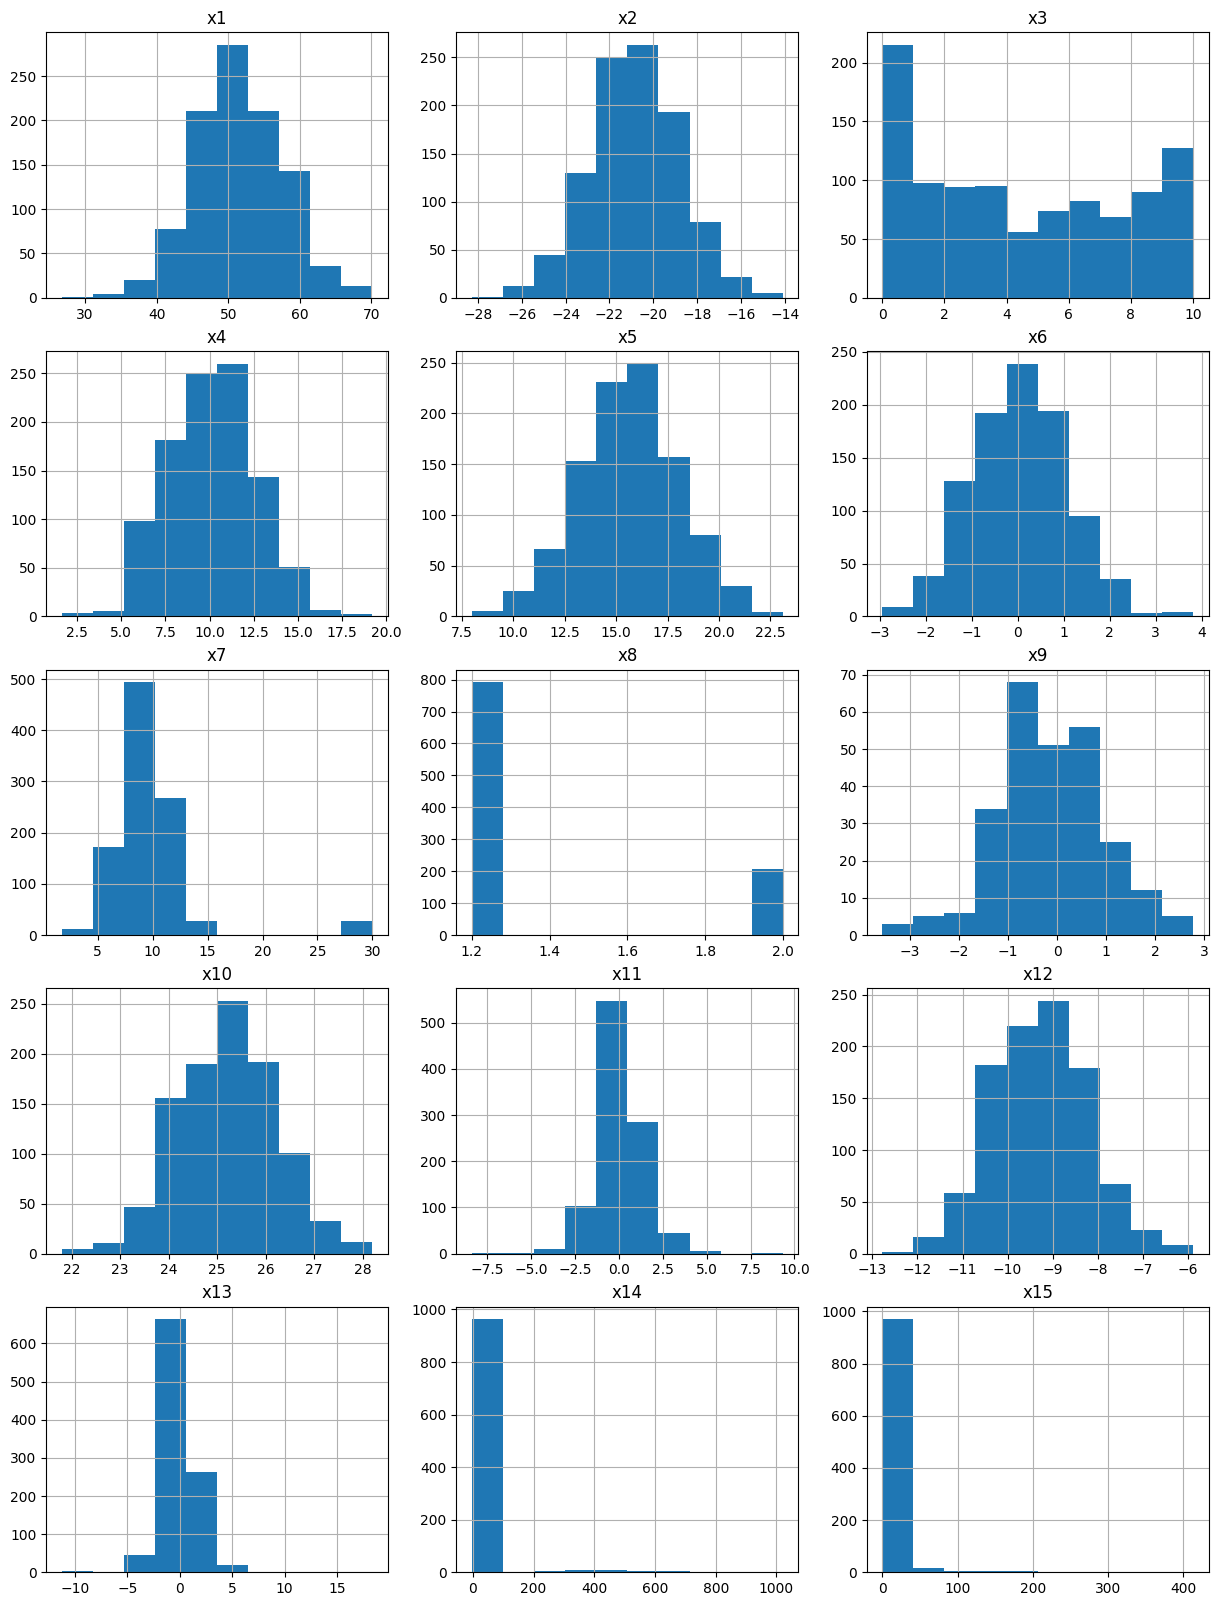

In [37]:
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
col_names = list(df.columns)
col_names.remove('y')
for i, col in enumerate(col_names):
  df[col].hist(ax=axs.flatten()[i])
  (axs.flatten()[i]).set_title(col)

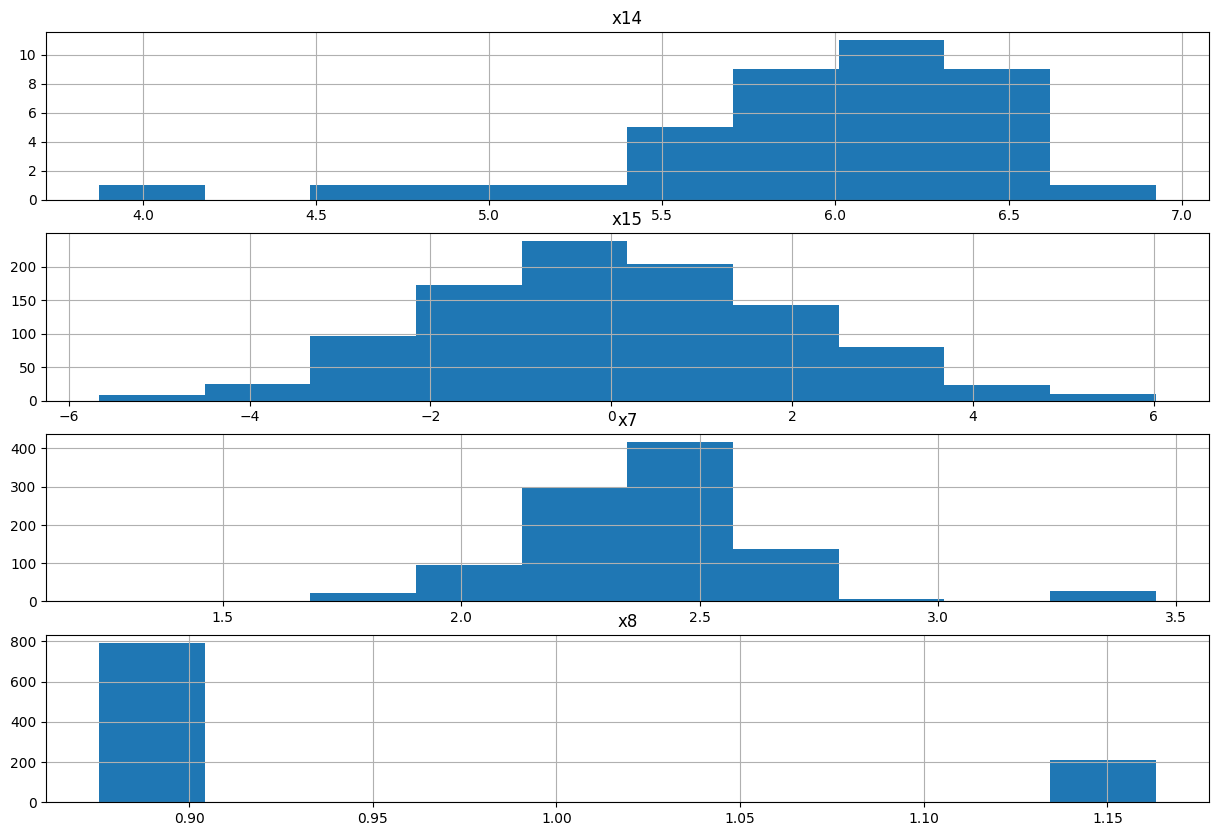

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

for i, col in enumerate(['x14', 'x15', 'x7', 'x8']):
  df[col].apply(lambda x: np.log(df[col].min() + x)).hist(ax=axs[i])
  axs[i].set_title(col)

In [7]:
df['y'].value_counts()

0    804
1    196
Name: y, dtype: int64

In [8]:
df['x8'].value_counts()
## only takes two values == maybe one hot encode these values

1.2    792
2.0    208
Name: x8, dtype: int64

In [9]:
for col in df.columns:
  print(col, ':', df[col].isnull().sum()/len(df))

x1 : 0.0
x2 : 0.0
x3 : 0.0
x4 : 0.0
x5 : 0.0
x6 : 0.063
x7 : 0.0
x8 : 0.0
x9 : 0.735
x10 : 0.0
x11 : 0.0
x12 : 0.0
x13 : 0.0
x14 : 0.0
x15 : 0.0
y : 0.0


# Let's replace `x9` with a feature indicating whether it's there or not
## Let's look at the distribution of `x6` to figure out what to imputer
## Additionally, let's transform `x14, x15` to log and let's one-hot encode `x8`

In [105]:
imputer = SimpleImputer(strategy='median')
x8_transformer = OneHotEncoder(handle_unknown='ignore')
x14_transformer = FunctionTransformer(lambda x: np.log(3.4 + x))
x15_transformer = FunctionTransformer(np.log)
x7_transformer = FunctionTransformer(np.log)

# df['x9_missing'] = df['x9'].apply(lambda x: 1 if x else 0)
# df = df.drop('x9', axis=1)

column_transformers = ColumnTransformer(
    transformers=[
        ('imputer', imputer, ['x6']),
        # ('one_hot', x8_transformer, ['x8']),
        ('log', x7_transformer, ['x7']),
        ('log1', x14_transformer, ['x14']),
        ('log2', x15_transformer, [ 'x15'])
        ],
        remainder='passthrough',
    )

In [43]:
column_transformers.fit_transform(df.drop('y', axis=1))

array([[ 5.24993038e-01,  1.00000000e+00,  0.00000000e+00, ...,
        -2.61184151e-03, -1.03377251e+01,  1.60798241e+00],
       [-4.28652075e-02,  1.00000000e+00,  0.00000000e+00, ...,
         2.16839461e-01, -9.58274916e+00, -1.43801607e+00],
       [ 2.92485311e-02,  1.00000000e+00,  0.00000000e+00, ...,
        -9.67696881e-01, -8.30629709e+00, -2.95474595e+00],
       ...,
       [ 2.92485311e-02,  1.00000000e+00,  0.00000000e+00, ...,
        -1.24445924e-01, -9.64230590e+00,  2.08970643e-01],
       [-4.66790995e-02,  0.00000000e+00,  1.00000000e+00, ...,
        -1.57829496e+00, -9.07084953e+00, -4.15623550e-01],
       [-3.19171505e-01,  0.00000000e+00,  1.00000000e+00, ...,
         2.52588257e+00, -8.02851711e+00, -1.23096873e+00]])

In [44]:
df['x9_missing'] = df['x9'].apply(lambda x: 1 if x else 0)
df = df.drop('x9', axis=1)

In [102]:
df['x8'] = df['x8'].apply(lambda x: 1 if x == 2.0 else 0)


In [106]:
def eval_model(model, poly=False, kern=False):
  if poly:
    pipeline = Pipeline(
      steps=[('columns', column_transformers),
             ('poly', PolynomialFeatures(2)),
             ('scale', StandardScaler()),
             ('model', model)])
  elif kern:
    pipeline = Pipeline(
      steps=[('columns', column_transformers),
             ('kern', Nystroem(n_components=400, random_state=42)),
             ('scale', StandardScaler()),
             ('model', model)])
  else:
    pipeline = Pipeline(
        steps=[('columns', column_transformers),
              ('scale', StandardScaler()),
              ('model', model)])

  metrics = []
  kfolds = StratifiedKFold(shuffle=True, random_state=42)

  X = df.drop('y', axis=1)
  y = df['y']
  for fold, (idx_train, idx_val) in enumerate(kfolds.split(X, y)):
    X_train = X.loc[idx_train]
    y_train = y.loc[idx_train]
    X_test = X.loc[idx_val]
    y_test = y.loc[idx_val]

    pipeline.fit(X_train, y_train)
    try:
      y_pred = pipeline.predict_proba(X_test)[:, 1]
    except:
      y_pred = pipeline.decision_function(X_test)
    auc = roc_auc_score(y_test, y_pred)
    metrics.append(auc)
  return metrics


In [123]:
# Ridge Regression

for C in np.logspace(-2, 2, 9):
    aucs = eval_model(RidgeClassifier(alpha=C, random_state=42))
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.01, AUC = 0.8654120232122949
C= 0.03162277660168379, AUC = 0.8653489210065297
C= 0.1, AUC = 0.8654126254180602
C= 0.31622776601683794, AUC = 0.8654757276238255
C= 1.0, AUC = 0.8655700798295907
C= 3.1622776601683795, AUC = 0.8656325798295906
C= 10.0, AUC = 0.8658603629160695
C= 31.622776601683793, AUC = 0.8654541129160694
C= 100.0, AUC = 0.8647251254180602


In [122]:
# Logistic Regression
for C in np.logspace(-2, 1, 9):
    aucs = eval_model(LogisticRegression(C=C))
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.01, AUC = 0.8507368460344005
C= 0.023713737056616554, AUC = 0.8609540482162764
C= 0.05623413251903491, AUC = 0.8648062937967829
C= 0.1333521432163324, AUC = 0.8650166129160693
C= 0.31622776601683794, AUC = 0.8650730908584169
C= 0.7498942093324559, AUC = 0.8655172151218347
C= 1.7782794100389228, AUC = 0.8652287386526517
C= 4.216965034285822, AUC = 0.8647191033604077
C= 10.0, AUC = 0.8647185011546424


In [47]:
# Polynomial Logistic Regression
for C in np.logspace(-3, -1, 9):
    aucs = eval_model(LogisticRegression(C=C), poly=True)
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.001, AUC = 0.8582899048415353
C= 0.0017782794100389228, AUC = 0.8612352982162765
C= 0.0031622776601683794, AUC = 0.8617250607182673
C= 0.005623413251903491, AUC = 0.861404732043319
C= 0.01, AUC = 0.8611168577799013
C= 0.01778279410038923, AUC = 0.8602911092530657
C= 0.03162277660168379, AUC = 0.8592466107262304
C= 0.05623413251903491, AUC = 0.8581390099936297
C= 0.1, AUC = 0.8571227504379678


In [24]:
# Kernel Approximation for Logistic Regression
for C in np.logspace(-3, -1, 9):
    aucs = eval_model(LogisticRegression(C=C), kern=True)
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.001, AUC = 0.7980009505892658
C= 0.0017782794100389228, AUC = 0.7996565983835004
C= 0.0031622776601683794, AUC = 0.7971588778069756
C= 0.005623413251903491, AUC = 0.7937765219382067
C= 0.01, AUC = 0.7870935807851568
C= 0.01778279410038923, AUC = 0.780172683747412
C= 0.03162277660168379, AUC = 0.7727541955327281
C= 0.05623413251903491, AUC = 0.7641361632027392
C= 0.1, AUC = 0.7551142896958114


In [50]:
# Linear SVM
for C in np.logspace(-4, -1, 4):
    aucs = eval_model(LinearSVC(C=C))
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.0001, AUC = 0.8128530468625577
C= 0.001, AUC = 0.8573115195492912
C= 0.01, AUC = 0.8652401805621915
C= 0.1, AUC = 0.8651055452699475


In [51]:
# Poly SVM
for C in np.logspace(-4, -1, 4):
    aucs = eval_model(LinearSVC(C=C), poly=True)
    print(f'C= {C}, AUC = {np.mean(aucs)}')

C= 0.0001, AUC = 0.8612863563067368
C= 0.001, AUC = 0.8595699504300048
C= 0.01, AUC = 0.8566822394091416


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C= 0.1, AUC = 0.8520547011864947


In [25]:
# Extra Trees Classifier
for min_samples_leaf in [5, 10, 20, 50, 100]:
  aucs = eval_model(ExtraTreesClassifier(n_estimators=300,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1))
  print(f'min sample leaves= {min_samples_leaf}, AUC = {np.mean(aucs)}')

min sample leaves= 5, AUC = 0.8484775541487497
min sample leaves= 10, AUC = 0.8493322085523172
min sample leaves= 20, AUC = 0.8475732401656314
min sample leaves= 50, AUC = 0.8423381659101767
min sample leaves= 100, AUC = 0.8292260262382545


In [26]:
# Random Forest Classifier
for min_samples_leaf in [5, 10, 20, 50, 100]:
  aucs = eval_model(RandomForestClassifier(n_estimators=300,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1))
  print(f'min sample leaves= {min_samples_leaf}, AUC = {np.mean(aucs)}')

min sample leaves= 5, AUC = 0.8404724777034559
min sample leaves= 10, AUC = 0.8434852534241122
min sample leaves= 20, AUC = 0.8468399725274726
min sample leaves= 50, AUC = 0.8351100593247333
min sample leaves= 100, AUC = 0.8266357600732601


In [27]:
for n_neighbors in range(200, 800, 100):
    auc = eval_model(KNeighborsClassifier(n_neighbors=n_neighbors,
                                                       weights='distance'))
    print(f'number neighbors= {n_neighbors}, AUC = {np.mean(aucs)}')

number neighbors= 200, AUC = 0.8266357600732601
number neighbors= 300, AUC = 0.8266357600732601
number neighbors= 400, AUC = 0.8266357600732601
number neighbors= 500, AUC = 0.8266357600732601
number neighbors= 600, AUC = 0.8266357600732601
number neighbors= 700, AUC = 0.8266357600732601


In [28]:
auc = eval_model(HistGradientBoostingClassifier(random_state=1))

print(f'AUC = {np.mean(aucs)}')

AUC = 0.8266357600732601


Text(0.5, 1.0, 'ROC Curve (AUC = 0.8841780376868096)')

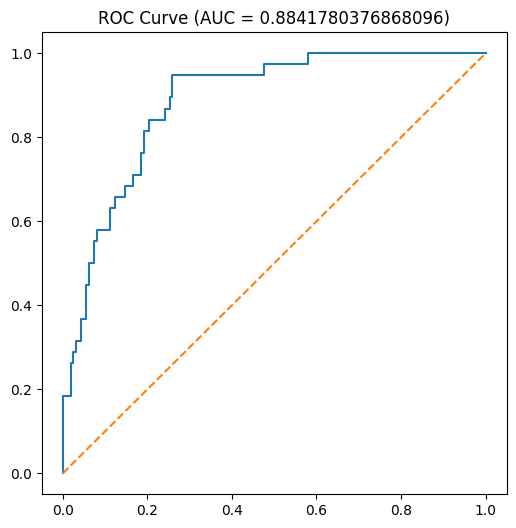

In [126]:
classifier = RidgeClassifier(alpha=10)
pipeline = Pipeline(
        steps=[('columns', column_transformers),
              ('scale', StandardScaler()),
              ('model', classifier)])

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


pipeline.fit(X_train, y_train)
y_preds = pipeline.decision_function(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), ls='dashed')
ax.set_title(f'ROC Curve (AUC = {roc_auc})')

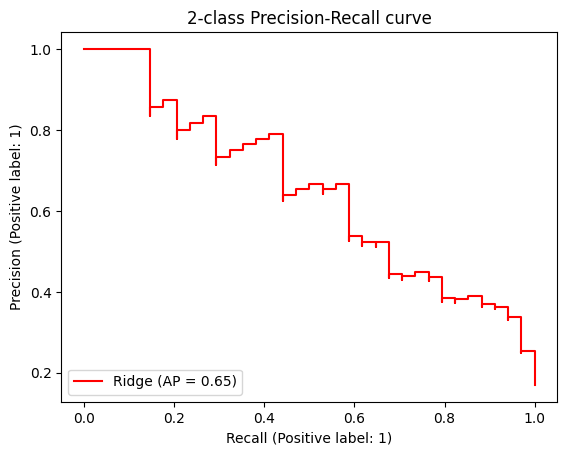

In [118]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_preds, name="Ridge",color='r'
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

<Axes: ylabel='Feature'>

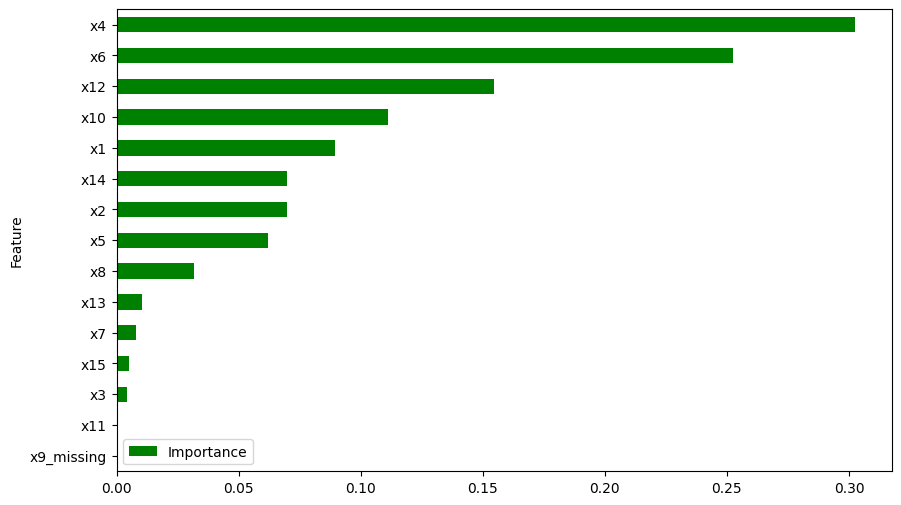

In [116]:
coefficients = pipeline[-1].coef_

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients).squeeze(0)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), color='g')
